# text2poem

### Aim
Given a textual description, generate a poem from it. 

### To-Do
- [ ] Clean up the variable names, etc
- [ ] Understand the T5 architecture and freeze the base layers if needed
- [ ] Create the $(\text{summary}, \ \text{poem})$ dataset using sites like [Poem Analysis](https://poemanalysis.com/). Ideally, smaller poems would be preffered. Might need to create manually, as scraping is not only difficult, but also lead to bad data. Stanza-by-Stanza is too detailed, and some summaries barely contain any information about the poem. Thus, data samples may need to be manually checked. Need to select famous poems that have good quality summaries available.
    - Doesn't work properly when tested with training set of $9$ poems, will need to try with more data
    - Another alternative, $(\text{topic}, \ \text{poem})$ dataset. Given a set of keywords, generate a poem. Dataset creation would be simple using LDA topic modelling etc.
        - [Topic Idenitification NLP 1](https://www.pluralsight.com/guides/topic-identification-nlp)
        - [Topic Idenitification NLP 2](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)
        - [Example](https://monkeylearn.com/keyword-extractor-online/)
- [ ] Clean the dataset, remove very long poems, if possible select by prominent authors, remove poems with no rhyming scheme.
- [ ] Change the RAKE algorithm
    - Maybe try using POS tagging in some way
- [ ] Check whether tokenizer preserves "\n" else replace by some other token
    - It's based on SentencePiece which doesn't preserve "\n"
- [ ] Calculate lengths of poems after data cleaning
### Ideas
- [ ] Rhyming scheme as T5 prefix

### References
- [Base code for this notebook](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb) (This had quite a few bugs) 
- [T5 finetuning tips](https://discuss.huggingface.co/t/t5-finetuning-tips/684/2)
- [T5 Docs](https://huggingface.co/transformers/model_doc/t5.html)
- [Training T5](https://huggingface.co/transformers/model_doc/t5.html#training) (Not detailed enough)
- [Finetuning T5](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb) (Probably the most extensive tutorial)
- [Few Shot Learning with T5](https://towardsdatascience.com/poor-mans-gpt-3-few-shot-text-generation-with-t5-transformer-51f1b01f843e)
- [Some Famous Poetry](https://medium.com/@EmEmbarty/31-of-the-best-and-most-famous-short-classic-poems-of-all-time-e445986e6df)
- [Poetry Summaries](https://www.litcharts.com/poetry/)
- [A great blog on how to generate text](https://huggingface.co/blog/how-to-generate)


## Install Dependencies

In [1]:
# Transformer changes very frequently, thus the version is important
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 12.4MB/s 
     |████████████████████████████████| 3.3MB 51.0MB/s 
     |████████████████████████████████| 901kB 56.8MB/s 
     |████████████████████████████████| 1.1MB 17.8MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [61]:
%reset -f

## Import Libraries

In [62]:
# General libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# The T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [63]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [64]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/poem_topics_200_top_authors.csv"
MODEL_NAME = "t5-base"

SEED = 42

# Specified in the number of tokens
MAX_LEN = 512
SUMMARY_LEN = 512

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 10 # 5 is good enough for 5k samples in data
LR = 3e-4

In [65]:
# Set random seeds and make pytorch deterministic for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

## Helper Functions

In [66]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [67]:
def replaceSep(text, sep = " | "):
    if type(text) == float:
        print(text)
    return text.replace("\n", sep)

In [68]:
def loadDF(path, n_rows = None, prefix = "poemify: "):
    """ Loads the CSV data and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")
    df.dropna(inplace = True)
    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]
    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)
    # Add a suitable prefix to the text input
    df.input = prefix + df.input
    # Truncate the dataset if required
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    df["input"] = df["input"].apply(replaceSep, sep = ", ")
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)
    
    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [69]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders, shuffle = False since we already shuffled once while creating the train-test split
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [70]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

In [71]:
# ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
# ds_train[0] # For quickly testing the data format

In [72]:
# temp = tokenizer(
#     ["hello\nmy friend* how| are|you today*haha"],
#     # max_length = self.inp_len, 
#     #padding = "max_length", 
#     #truncation = True,
#     return_tensors = "pt"
# ).input_ids
# ok = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in temp]
# print(ok)

## Train and Validate Functions:

In [73]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
                
        loss_batches.append(loss.item())
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss_batches

In [74]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

In [130]:
def generate(topics):

    input = "poemify: " + " , ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        max_length = 1024,
        num_beams = 1,
        # early_stopping = True,
        no_repeat_ngram_size = 2
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [117]:
def genSample(topics, min_length, max_length, rep_penalty, temp = 1):

    input = "poemify: " + ", ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        temperature = temp,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [77]:
# gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"])

## Main

In [78]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [79]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = "poemify: ")
print(len(df), len(df_train), len(df_val))

487 482 5


In [80]:
display(df)

,output,input
0,"I have no wit, no words, no tears; | My heart ...","poemify: frozen thing, shall-the sap, royal cu..."
1,"A Bird, came down the Walk - | He did not know...","poemify: softer Home, frightened Beads, rapid ..."
2,My heart is like a singing bird | Whose nest i...,"poemify: rainbow shell, singing bird, silver f..."
3,"You did not come, | And marching Time drew on,...","poemify: little hour, high compassion, pure lo..."
4,"Out of a fired ship, which by no way | But dro...","poemify: burnt ship, fired ship, shot decay, f..."
...,...,...
484,"Sweet and low, sweet and low, | Wind of the we...","poemify: rolling waters, western sea, silver m..."
485,"Tears, idle tears, I know not what they mean, ...","poemify: glimmering square, divine despair, id..."
486,The splendour falls on castle walls | And snow...,"poemify: cataract leaps, wild cataract, rich s..."
487,"Thy voice is heard thro' rolling drums, | That...","poemify: thy knee, face, blow, dead, fancy, ha..."


In [81]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

241 3


### Loading the Model

In [82]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [83]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 222,903,552 trainable and 0 frozen parameters


### Optimization

In [84]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [85]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}")
    loss_batches = train(e, tokenizer, model, dl_train, optimizer)
    losses += loss_batches

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10


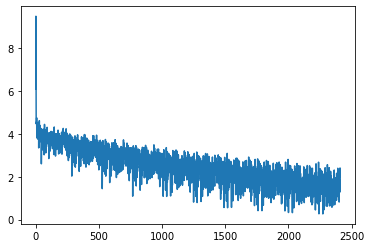

In [86]:
plt.plot(range(len(losses)), losses)
plt.show()

In [87]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [88]:
display(results)

,Generated Text,Actual Text
0,"I heard a flood | Of foam and deep Turns, wher...","Sunset and evening star, | And one clear call ..."
1,"I am young Stephen, | Who came to me with my s...","And did young Stephen sicken, | And did young ..."
2,"O thou cansest drop from my nest, | Thou haste...",Ethereal minstrel! pilgrim of the sky! | Dost ...
3,"I | Loved the Lord Godwin in his pleasant lot,...",Where sunless rivers weep | Their waves into t...
4,"I | Have not the sense to speak of, or say tha...","Up! up! my Friend, and quit your books; | Or s..."


In [98]:
x = 3
print(results.iloc[x]["Generated Text"], "\n")
print(results.iloc[x]["Actual Text"])

I | Loved the Lord Godwin in his pleasant lot, | And he and all of us who love him with charmed sleep. | | But when we were little more than two stars apart, | We parted ways not one by means other that seemed to be: | Nor did our hearts beat like clocks; nor could they sing without interruption or delay? | No matter what their mood was at any moment it felt for them either!-It seems as though heaven had cast out its spell on me personally, but my heart would look pale beyond measure." 

Where sunless rivers weep | Their waves into the deep, | She sleeps a charmed sleep: | Awake her not. | Led by a single star, | She came from very far | To seek where shadows are | Her pleasant lot. | | She left the rosy morn, | She left the fields of corn, | For twilight cold and lorn | And water springs. | Through sleep, as through a veil, | She sees the sky look pale, | And hears the nightingale | That sadly sings. | | Rest, rest, a perfect rest | Shed over brow and breast; | Her face is toward the 

In [119]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.3, 0.9)

Let me not be discouraged by the wind:
I am bound by this, my dearest!
I live in a forest close to God's house;
But I cannot keep my promise to you, that all my life shall be free from evil.
My heart is with you, that every moment of your life shall be happy.
I feel for you and for me, that every day is gladly coming out of nowhere.
For I am but one of many things that are desolate and unequal:
For I hear the sounds of rustling through the weeping tree;
For how can I have lost a leaf when I die,
Or when I die I die, I will lose it.


In [120]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.4, 0.7)

The wind is still blowing in the forest,
Through the weeping rain and weeping waves;
The forest is dark and desolate, but the sky is cloudy.
I wonder if this tree can stand up and sing:
It will not weep or weep until it is springing out of my bed.

If this were so, I would not weep for joy.

I should have felt the loss of this love when I was young:
I must die that day,
When all things are done,
And leave the feeling alone!


In [124]:
gen = genSample(["happy", "elated smile", "good luck", "beautiful eyes"], 100, 500, 1.5, 0.9)

Is it that you dream of me?
Are your beautiful eyes?
Have shined the most elated smile on my face:
May be, as always, at times, happy or sad.
Wish me luck!
And have had many good days with you!
If only one look could bring you happiness;
Or are indeed well-matched by those who seek
To give you some real peace and joy.
Would not fail to please when tears roll down your faces:
Had you visions without an elated smile but love in unexpected places?


In [126]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.5, 0.9)

I saw the blossoming sun,
On the happy faces of trees with their red and gold wings.

Yet when night wore out all smiles,
And beaming brightly in the glowing sun,
He gazed across smiling faces like clouds;
An elated smile on my lips was seen:
For joyous living in these beautiful surroundings became reality.

As dancing trees near me showed,
With their joyful face I seemed to wince and groan as ever before.


In [127]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.4)

A joyous, elated smile,
Faces that bear the glow of the sun;
With dancing trees comes the joyous love of nature.

In the glowing sun there is peace in playing fields;
He loves to see everything:-whether its foet from his feet or with his eyes alone;
Or just one smiling face among happy faces alone.

I look upon these happy faces for inspiration and for cheer;
And as at times my heart feels like an Eternity strike,
(And so does Life).


In [129]:
gen = genSample(["hoary sky", "consistent light", "long time", "taking", "silly" ,"back", "animals", "tired"], 100, 500, 1.4, 0.8)

The birds are tired from being in the hoary sky,
And without a consistent light for a long time.
They call me back when tired and tired;
And when they need water they go out to bed,
With no reason why they sleep so little or no more.

They sit on their backs like rats in the woods,
Their eyes are tired of being sunned by bad nights:
They have looked at me for too long while,
And I know that I am old enough
To stay awake all night.


## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```